# An introduction to neural networks using Digital Rocks
© Javier E. Santos, Bernard Chang and Maša Prodanović. 2021. Apache License 2.0.

-------------------------------------------------------------------------
Throughout this notebook we will develop and train neural networks for different petrophysical applications. We will attempt to provide the user with intuition behind how these networks work and best training practices. Let's keep in mind that this notebook is intended to be executed in a 2-hr workshop, so many important concepts will be neglected for the sake of brevity.

-------------------------------------------------------------------------
A great comprehensive resource is the convolutional neural network class (CS321N) from Stanford University. This can be streamed here: [CS321N youtube playlist link](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv). 

Many of the concepts shown in this notebook were originally developed for the 3D ConvNet called MS-Net (https://doi.org/10.1007/s11242-021-01617-y). However, this code is new and available only to DRP IAP members.

## Before we begin...
### Run the following cell to clone our workshop repo.
The repository we will be using is a fork of https://github.com/je-santos/ms_net.

In [2]:
from tqdm.notebook import trange
from tqdm import tqdm_notebook


for i in trange(1, desc='Install workshop packages'):
  # Our workshop repository
  !git clone https://github.com/BC-Chang/ms-net-workshop.git &> /dev/null

  import os
  os.chdir('ms-net-workshop')  # Set working directory

  # Data loading package
  !pip install hdf5storage &> /dev/null

  # Install Live Loss Plot Package
  !pip install git+https://github.com/je-santos/livelossplot &> /dev/null

  # Install Pyvista 3D Visualization
  # !pip install pyvista
  # !apt-get install -qq xvfb
  # !pip install pyvista panel -q

Install workshop packages:   0%|          | 0/1 [00:00<?, ?it/s]

The syntax of the command is incorrect.


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'ms-net-workshop'

### Import some packages

In [33]:
# Pytorch packages
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau# as reduceLR

import numpy as np
from hdf5storage import loadmat # Data loading
from scipy.ndimage.morphology import distance_transform_edt  # Euclidean Distance function

# Network packages
from network import MS_Net 
from pore_utils import scale_tensor
from network_tools import get_masks


# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from matplotlib.patches import Ellipse, Polygon
import seaborn as sns
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display
from livelossplot import PlotLosses
# import pyvista


In [32]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/BC-Chang/ms-net-workshop
   b39eebe..0435e74  main       -> origin/main
Updating b39eebe..0435e74
Fast-forward
 images/EmptyNeuralNet1.png | Bin 0 -> 38647 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 images/EmptyNeuralNet1.png


# 1.0 Introduction

Where are we?

![](https://www.google.com/images/logos/google_logo_41.png) Colab
- Google colab is an enviroment by that allows to write and execute python code directly in a browser. It doesn't require any prior configuration or software installation.

    - It also provides free GPU access: Runtime -> change runtime type

In [14]:
print(f'This is a code cell. One can perform operations here: 1+3 = {1+3}')
# One can you this cell with the play button or with shift+enter

This is a code cell. One can perform operations here: 1+3 = 4


<-- To the left there is button to display the table of contents, in case anyone gets lost along the way

A very common error is:

In [15]:
raise NameError('x is not defined')

NameError: ignored

This is likely to happen when previous cells of code were not run.

## 1.1 What is a neuron?

A neuron performs a mathematical operation where the input data ($x$) is multiplied by a $\textbf{weight}$ ($w$) followed by the addition of a $\textbf{bias}$ ($b$). These weights and biases are called $\textbf{trainable parameters}$.

$y=x*w+b$

Additionally, this output can be passed through a non-linear activation function.

$y_{_{NL}} = f(y)$

Some examples of non-linearities commonly used in NN are the following:

- $\text{ReLU}(y)     = \text{max}(0, y)$

- $\text{sigmoid}(y) = \frac{1}{1 + \text{e}^{-y}}$

- $\text{tanh}(y) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

Each function has distinct properties that can benefit certain applications.

IntRangeSlider(value=(-10, 10), description='Input range:', max=10, min=-10)

FloatSlider(value=1.0, description='Weight value:', max=5.0, min=-5.0)

FloatSlider(value=0.0, description='Bias value:', max=5.0, min=-5.0)

RadioButtons(description='Activation:', options=('linear', 'ReLU', 'sigmoid', 'tanh'), value='linear')

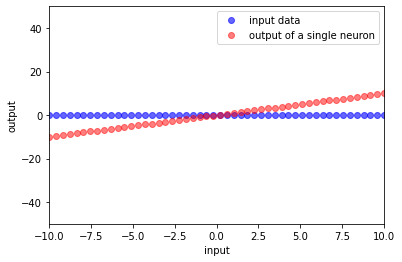

In [43]:
## @title 1.2 A single neuron

xi = widgets.IntRangeSlider()
xi.min = -10
xi.max =  10
xi.value= [-10, 10]
xi.description='Input range:'
display(xi)


w = widgets.FloatSlider()
w.value= 1
w.min = -5
w.max =  5
w.description='Weight value:'
display(w)

b = widgets.FloatSlider()
b.value= 0
b.min = -5
b.max =  5
b.description='Bias value:'
display(b)

act = widgets.RadioButtons()
act.options=['linear','ReLU','sigmoid', 'tanh']
act.description = 'Activation:'
display(act)

    
def plot_w(*args):
    print(f'Hi my first value is {xi.value[0]}')
    x_t = np.linspace(xi.value[0],xi.value[1])
    y_t = x_t*w.value+b.value
    lim = ([-50, 50])
    if act.value=='sigmoid':
        y_t = 1 / (1 + np.exp(-y_t))
        lim = ([-0.5, 1.2])
    if act.value=='ReLU':
        y_t = np.maximum(y_t,0)
    if act.value=='tanh':
        y_t = (np.exp(y_t) - np.exp(-y_t))/(np.exp(y_t)+np.exp(-y_t))
        lim = ([-1.2, 1.2])

    #plt.figure(1)
    #plt.close()
    clear_output(wait=True)
    display(xi,w,b,act)
    plt.plot(x_t, np.zeros_like(x_t), 'bo', alpha=0.6)
    plt.plot(x_t, y_t, 'ro', alpha=0.5)
    plt.ylim(lim)
    plt.xlim([-10 ,10])
    plt.legend(['input data','output of a single neuron'])
    plt.xlabel('input')
    plt.ylabel('output')
    plt.show()

plot_w()

xi.observe(plot_w,'value')
w.observe(plot_w,'value')
b.observe(plot_w,'value')
act.observe(plot_w,'value')


The neuron is the basic building block in neural networks. Although the concept is simple, when we nest several of these, we can fit very complicated functions.

$y = f(x*w_1+b_1)$ can be the output of a previous layer (one or multiple neurons).

## 1.3 How does a neuron learn?

The values of the neuron's weight ($w$) and  bias ($b$) are adjusted (or trained) using the training data provided. These parameters are trained by minimizing the function:

$Loss = loss\_f(y_{pred}, y_{true})$

Intuitively, this process can be seen as minimizing the error (or mismatch) of the training data with the output of the neural network. Common loss functions ($\text{$loss\_f$}$) for inference include mean squared error ($\textit{MSE}$) and mean absolute error ($\textit{MAE}$), and binary cross-entropy for segmentation.

## 1.4 What happens when we use multiple neurons? 

![image here](https://raw.githubusercontent.com/je-santos/MPLBM-UT/master/illustrations/playground.png)


Let's go to: https://playground.tensorflow.org


## 2.1 Training our first neural network
We'll start with the simplest neural network architecture. A model with one neuron, which is equivalent to a linear regression:

$y=x*w_1+b_1$

We will use mean square error:

$\text{MSE}(y_{pred},y)=\frac{1}{N}\sum(y_{pred}-y)^2$

and the ADAM optimizer:

$\theta_{t+1} = \theta_{t}-LR\frac{v_t}{\sqrt{s_t+\epsilon}}\cdot g_t$

Where $v_t$ and $s_t$ are the first and second gradient moments respectively  

## Load in data
Single berea pore.

Image size = 108 x 108 x 108

In [ ]:
x = loadmat('./example_data/berea_pore_108.mat')['bin']
y = loadmat('./example_data/berea_pore_108_detrended.mat')['detrended_dom']
phi = loadmat('./example_data/berea_pore_108_elec.mat')['phi']
linear = loadmat('./example_data/berea_pore_108_linear_trend.mat')['linear']
edist = distance_transform_edt(x)
edist = edist / np.amax(edist)

## Data Preprocessing
### Data Visualization

(-0.5, 107.5, 107.5, -0.5)

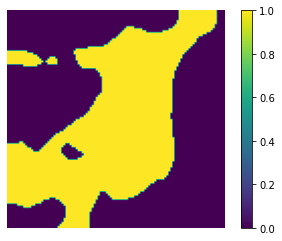

In [ ]:
# TODO Can we do 3D Visualization of this?

plt.imshow(x[:,54,:], vmin=0, vmax=1); 
plt.colorbar()
plt.axis('off')


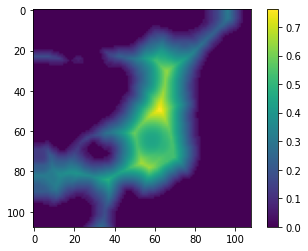

In [ ]:
plt.imshow(edist[:,54,:]);
plt.colorbar()


(-0.5, 107.5, 107.5, -0.5)

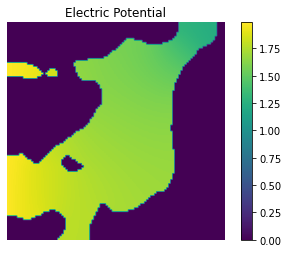

In [ ]:
plt.imshow(phi[:,54,:]); plt.colorbar()
plt.title('Electric Potential')
plt.axis('off')

(0.0, 107.0, 107.0, 0.0)

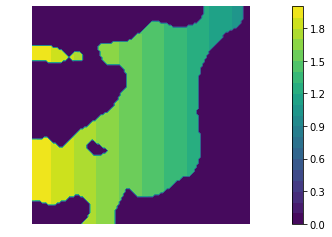

In [ ]:
plt.contourf(linear[:,54,:], levels=20); plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.axis('off')
plt.axis('equal')

(-0.5, 107.5, 107.5, -0.5)

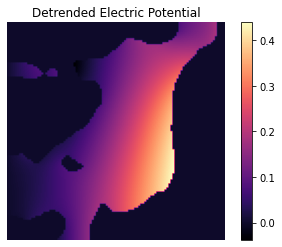

In [ ]:
# TODO Can we do 3D Viz w/ Pyvista?
y = phi - linear
plt.imshow(y[:,54,:], cmap='magma')
plt.colorbar()
plt.title('Detrended Electric Potential')
plt.axis('off')

### Normalize data and compute scales

In [ ]:
# This function normalizes the given data, converts to a Torch tensor,
# and downscales image to specified number of scales

def preprocess_data(data, num_scales=2):
  # Normalize data
  # data = data / np.amax(data)
  # data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))

  # Convert data into torch tensor
  data = torch.as_tensor(data, dtype=torch.float32)
  
  # Add dimensions to torch tensor
  data = data[None, None, :, :, :]

  # Compute data on different scales
  ds_data = []
  ds_data.append(data)
  for i in range( num_scales-1 ):
    ds_data.append( scale_tensor( ds_data[-1], scale_factor=1/2, mode='nearest') )
  
  data = ds_data[::-1] # Returns the reversed list (smallest images first)

  return data


In [ ]:
num_scales = 3

x_n = preprocess_data(x, num_scales)
y_n = preprocess_data(y, num_scales)

# Get masks
masks = get_masks(x_n[-1], scales=num_scales)

### Visualize scaled data

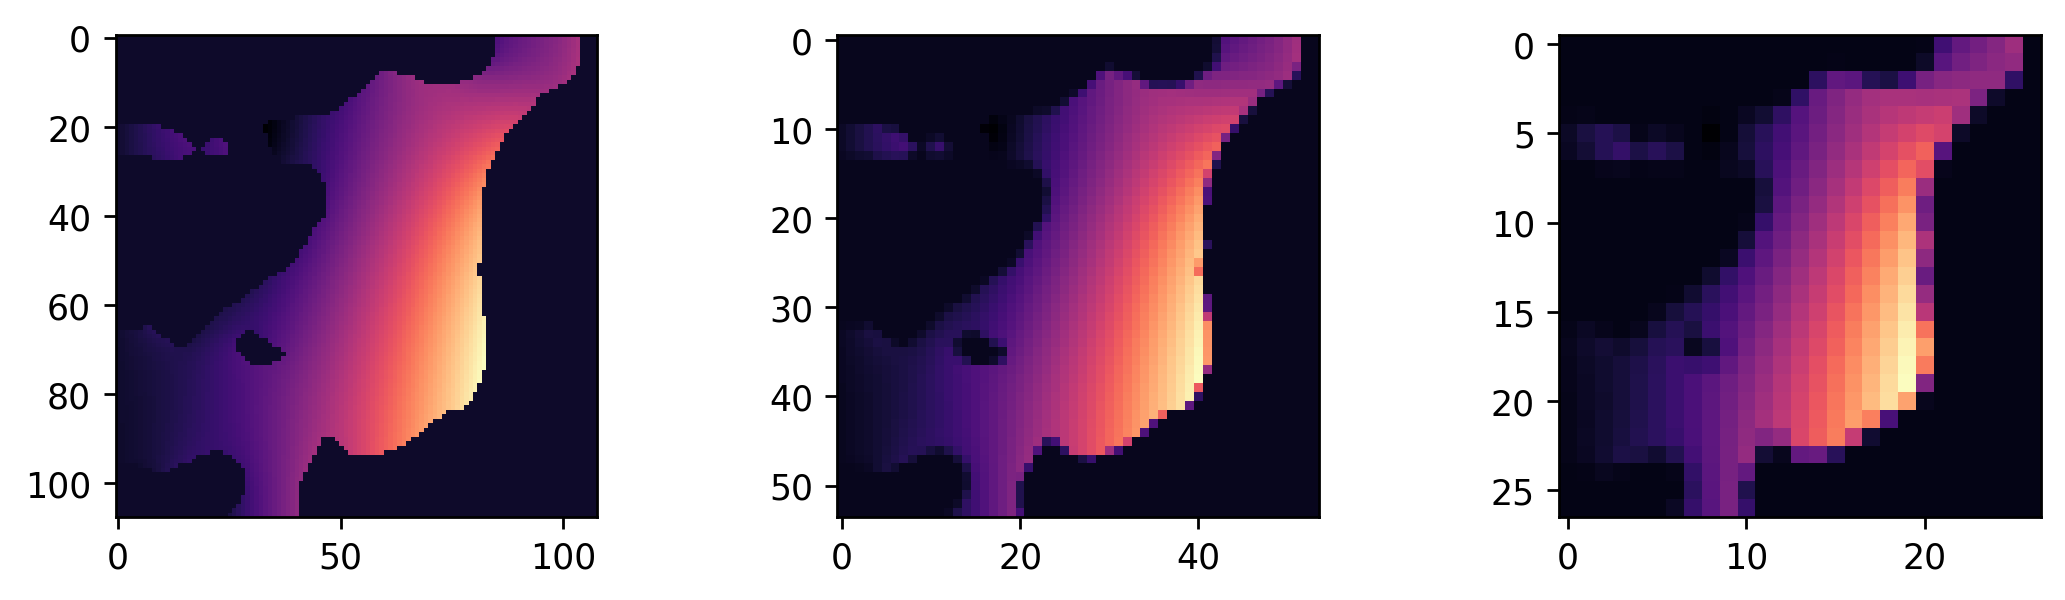

In [ ]:
fig = plt.figure(figsize=(11,8), dpi=250)

for i in range(num_scales):
  plt.subplot(1,num_scales,i+1)
  my_slice = int(y_n[-i-1].size()[-1]/2)
  plt.imshow(y_n[-i-1][0,0,:,my_slice,:], cmap='magma')

# plt.subplot(1,4,2)
# plt.imshow(y_n[-2][0,0,:,27,:], cmap='magma')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.5, hspace=0.05)

Text(0.5, 1.0, 'Detrended Data')

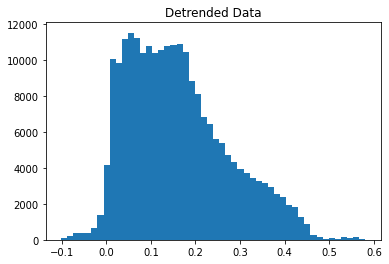

In [ ]:
# plt.subplot(1,2,1)

plt.hist(y[x==1].ravel(), 50)
plt.title('Detrended Data')


## Set up model

In [ ]:
device = 'cuda'  # Include this line to train on GPUs

bin_model = MS_Net(
    num_scales = num_scales,
    num_features = 1,
    num_filters = 6, 
    device = device,
    summary = False
)

Filters per model: [96, 24, 6]


In [ ]:
# Set up training parameters
learning_rate = 1e-5
epochs = 2000
model_name = 'workshop_bin_model'
optimizer = Adam(bin_model.parameters(), lr=learning_rate)  # Adam optimizer
scheduler  = ReduceLROnPlateau( optimizer, verbose=True, threshold=1e-6, min_lr=1e-6, patience = 25 )  # Learning rate scheduler
loss_f = nn.MSELoss()  # MSE loss function
loss = 1e9  # Initialize value of loss
best_loss = 1e10
liveloss = PlotLosses()


In [ ]:
# Send data to GPU
bin_model = bin_model.to(device)
masks = [m.to(device) for m in masks]
x_n = [x.to(device) for x in x_n]
y_n = [y.to(device) for y in y_n]

In [ ]:
def calc_loss(y_pred, y, loss_f, log):
    
    loss = 0
    y_var = y[-1].var()
    for scale, [y_hat,yi] in enumerate(zip(y_pred, y)):
        loss_scale = loss_f(y_hat,yi)#/y_var 
        loss += loss_scale
        prefix = f'scale_{scale}_'
        log[prefix + 'loss'] =  loss_scale.item()

    log['loss'] = loss.item()
    
    return loss, log

## Training Loop

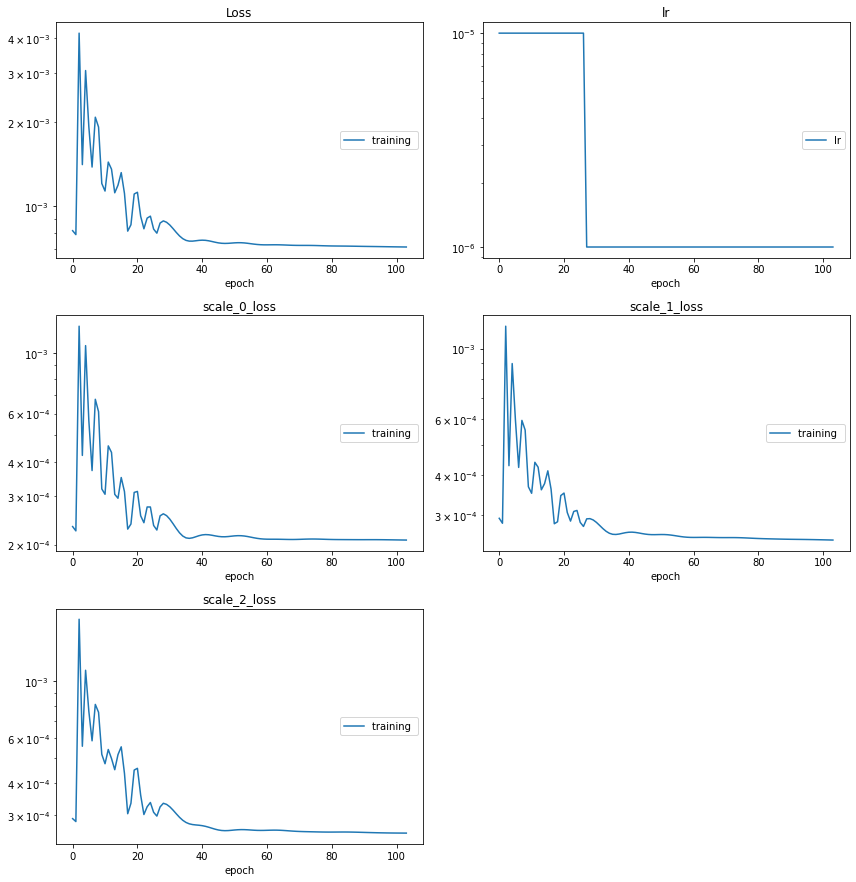

Loss
	training         	 (min:    0.001, max:    0.004, cur:    0.001)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
scale_0_loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
scale_1_loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
scale_2_loss
	training         	 (min:    0.000, max:    0.002, cur:    0.000)


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
    logs={}
    
    # clear the gradients
    optimizer.zero_grad()

    # compute the model output
    y_hat = bin_model(x_n, masks)

    loss_prev = loss
    loss, logs = calc_loss(y_hat, y_n, loss_f, logs) 

    # credit assignment
    loss.backward()

    # update model weights
    optimizer.step()
    # print('Loss: %r\n' %loss)
    scheduler.step(loss)
    # Save model
    if epoch % 100 == 0 and loss < best_loss:  # Save model every 100 epochs
        best_loss = loss
        print(f'Epoch: {epoch}, Best loss: {float(best_loss)}')
    
    logs['lr'] = optimizer.param_groups[0]['lr']
    liveloss.update(logs)
    liveloss.send()

    #     print('Saving model...')
    #     torch.save(net, f'{model_name}.pth')

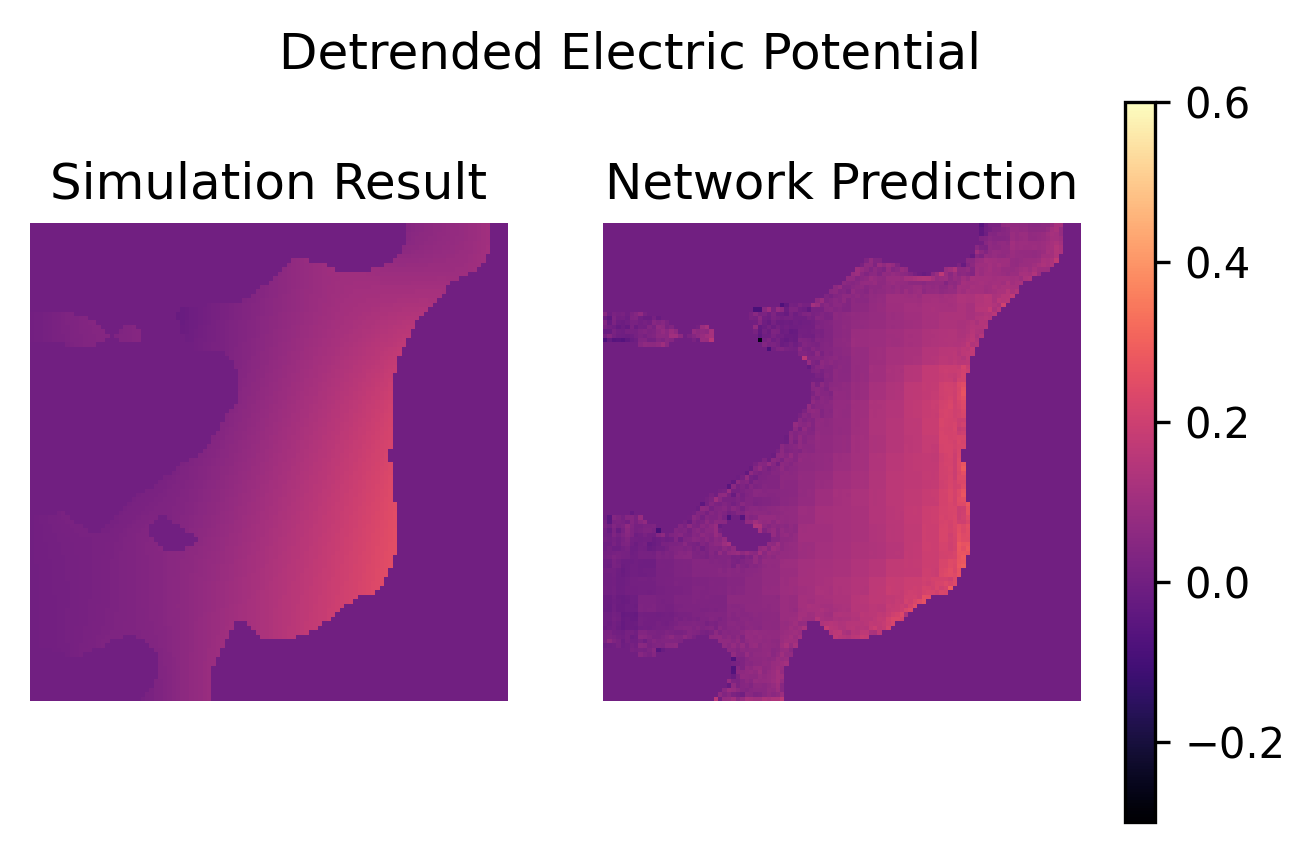

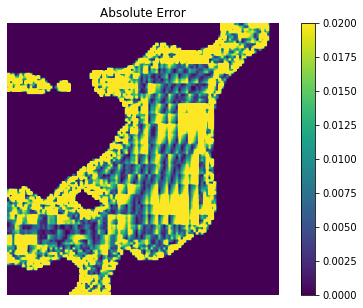

In [ ]:
#%% Evaluate Model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,3), dpi=300)

y_n = [y.cpu() for y in y_n]
axes[0].set_axis_off()
im = axes[0].imshow(y_n[-1][0,0,:,54,:]*np.amax(y), vmin=-0.3, vmax=0.6, cmap='magma')
axes[0].title.set_text('Simulation Result')

y_hat = [yh.cpu() for yh in y_hat]
pred = y_hat[-1].detach()

axes[1].set_axis_off()
im = axes[1].imshow(pred[0,0,:,54,:]*np.amax(y), vmin=-0.3, vmax=0.6, cmap='magma')
axes[1].title.set_text('Network Prediction')


plt.suptitle('Detrended Electric Potential')
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.01)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
# plt.show()

plt.figure(figsize=(8,5))
plt.axis('off')
im = plt.imshow(np.abs(y_n[-1][0,0,:,54,:] - pred[0,0,:,54,:]), vmin=0, vmax=0.02)#/y_n[-1][0,0,:,54,:] * 100, vmin=0, vmax=100)
plt.title('Absolute Error')
plt.colorbar()

In [ ]:
device = 'cuda'  # Include this line to train on GPUs

edist_model = MS_Net(
    num_scales = num_scales,
    num_features = 1,
    num_filters = 6, 
    device = device,
    summary = False
)

Filters per model: [96, 24, 6]


In [ ]:
# Set up training parameters
learning_rate = 1e-3
epochs = 1000
model_name = 'workshop_edist_model'
optimizer = Adam(edist_model.parameters(), lr=learning_rate)  # Adam optimizer
scheduler  = ReduceLROnPlateau( optimizer, verbose=True, threshold=1e-6, min_lr=1e-6, patience = 25 )  # Learning rate scheduler
loss_f = nn.MSELoss()  # MSE loss function
loss = 1e9  # Initialize value of loss
best_loss = 1e10
liveloss = PlotLosses()


In [ ]:
num_scales = 3

edist_n = preprocess_data(edist, num_scales)
y_n = preprocess_data(y, num_scales)

# Get masks
masks = get_masks(edist_n[-1], scales=num_scales)

In [ ]:
# Send data to GPU
edist_model = edist_model.to(device)
masks = [m.to(device) for m in masks]
edist_n = [ed.to(device) for ed in edist_n]
y_n = [y.to(device) for y in y_n]

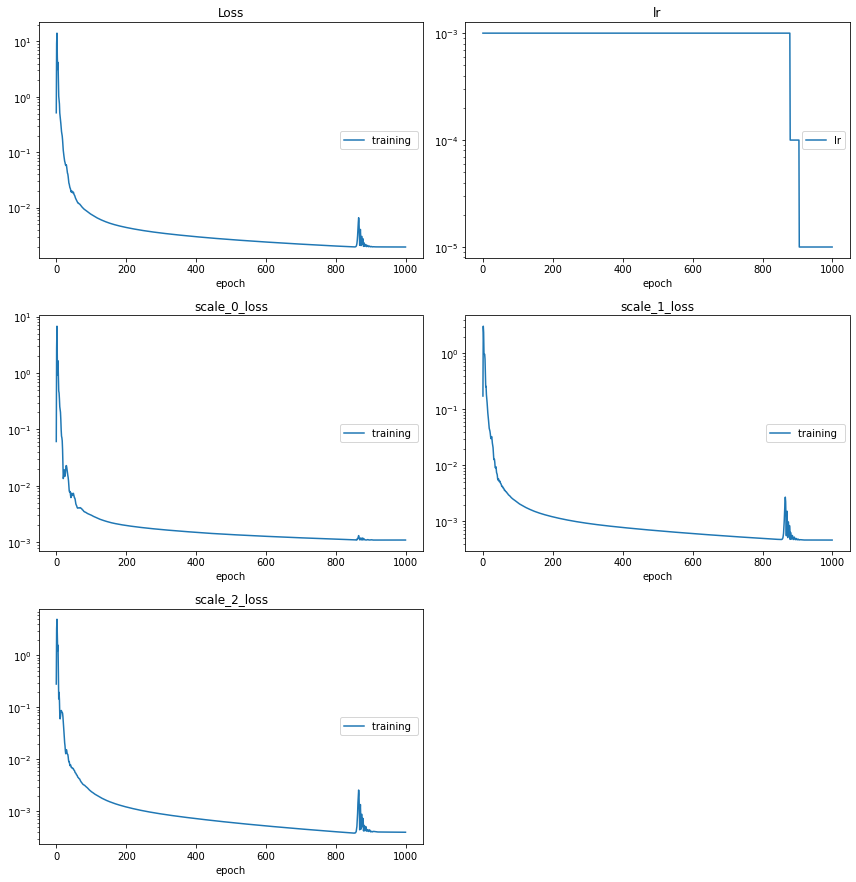

Loss
	training         	 (min:    0.002, max:   14.115, cur:    0.002)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
scale_0_loss
	training         	 (min:    0.001, max:    6.778, cur:    0.001)
scale_1_loss
	training         	 (min:    0.000, max:    3.057, cur:    0.000)
scale_2_loss
	training         	 (min:    0.000, max:    4.971, cur:    0.000)


In [ ]:
for epoch in range(epochs):
    logs={}
    
    # clear the gradients
    optimizer.zero_grad()

    # compute the model output
    y_hat = edist_model(edist_n, masks)

    loss_prev = loss
    loss, logs = calc_loss(y_hat, y_n, loss_f, logs) 

    # credit assignment
    loss.backward()

    # update model weights
    optimizer.step()
    # print('Loss: %r\n' %loss)
    scheduler.step(loss)
    # Save model
    if epoch % 100 == 0 and loss < best_loss:  # Save model every 100 epochs
        best_loss = loss
        print(f'Epoch: {epoch}, Best loss: {float(best_loss)}')
    logs['loss'] = loss.item()
    logs['lr'] = scheduler.optimizer.param_groups[0]['lr']
      
    liveloss.update(logs)
    liveloss.send()

    #     print('Saving model...')
    #     torch.save(net, f'{model_name}.pth')

In [ ]:
 !pip install pyvista
# !pip install ipyvtklink
# !pip install itkwidgets
# # setup enviornment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q
!

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 88.3 MB 101 kB/s 
     |████████████████████████████████| 158 kB 45.3 MB/s 
     |████████████████████████████████| 1.1 MB 33.8 MB/s 
     |████████████████████████████████| 160 kB 46.8 MB/s 
     |████████████████████████████████| 192 kB 27.5 MB/s 
     |████████████████████████████████| 271 kB 45.5 MB/s 
     |████████████████████████████████| 246 kB 5.3 MB/s 
     |████████████████████████████████| 130 kB 27.1 MB/s 
Selecting previously unselected package xvfb.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


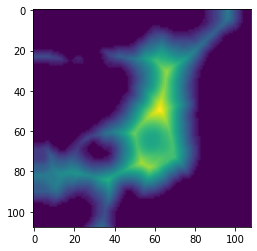

In [ ]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')



### new cell simple plot ###
pn.extension('vtk')  # this needs to be at the top of each cell for some reason
import pyvista as pv
sphere = pv.Sphere()
sphere.plot(color='w', notebook=True,  interactive=True, off_screen=False)





ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)